注意：

   - UHF 采样率在439.5k时，是连续采样
  
   - tf=1e-3，frq必须是kHz的整数倍！否则AWG输出的就不是严格的周期函数

In [1]:
import visa
import zhinst.utils
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
# from scipy.optimize import curve_fit
# from scipy import signal
# from scipy import integrate
# from scipy.integrate import simps
#from __future__ import print_function

# 定义平滑后的方波

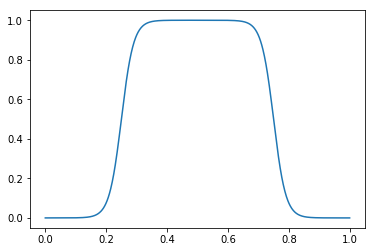

In [2]:
def squareSmooth_func(t_vec, T, V0):
    delta_t  = T/50
    return 1/(1+np.exp( (t_vec-T/4*3)/delta_t)) * (1 - 1/(1+np.exp( (t_vec-T/4)/delta_t)) ) * V0

T                = 1
V0               = 1
t_vec            = np.linspace(0,1,1001)
squareSingle_vec = squareSmooth_func(t_vec, T, V0)

plt.plot(t_vec, squareSingle_vec)

In [3]:
def squarePeriodic_func(t_vec, T, V0):
    N_period = int(float(np.round( ( (t_vec[-1] - t_vec[0]) / T ) )))
    N_singleT= int( t_vec.size / N_period)
    
    #定义单个周期中的信号
    tSingle_vec = np.linspace(0, T, N_singleT+1)[:-1] #扔掉末尾的点
    VSingle_vec = squareSmooth_func(tSingle_vec, T, V0)
    
    #将所有周期的信号连接起来
    output = np.array([])
    for n in range(N_period):
        output = np.concatenate( (output, VSingle_vec) )
        
    return output

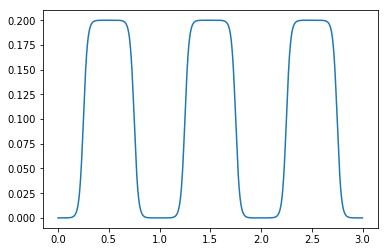

In [4]:
T     = 1
V0    = 0.2
t_vec = np.linspace(0, 3,3001)[:-1]

plt.plot(t_vec, squarePeriodic_func(t_vec, T, V0))
#plt.xlim([0,0.3e-4])

# AWG

In [5]:
# Set up VISA instrument object
rm = visa.ResourceManager()
awg = rm.open_resource('TCPIP0::169.254.102.2::inst0::INSTR')

#==== 初始化仪器 ====
awg.timeout = 25000
awg.encoding = 'latin_1'
awg.write_termination = None
awg.read_termination = '\n'
print('Connected to ', awg.query('*idn?'))
awg.write('*rst')
awg.write('*cls')

Connected to  TEKTRONIX,AWG70002A,B020178,FV:5.0.0112


(4, <StatusCode.success: 0>)

In [6]:
def AWG_read_check():
    awg.query('*opc?')

In [7]:
def setWfm_func(awg, wfm_name, recordLength, wfmData, N_output):
    #==== 将波形数据发送给仪器 ====
    # Send Waveform Data
    awg.write('wlist:waveform:new "{}", {}'.format(wfm_name, recordLength))
    stringArg = 'wlist:waveform:data "{}", 0, {}, '.format(wfm_name, recordLength)
    awg.write_binary_values(stringArg, wfmData*4)
    #暂时不知道为什么波形数据需要乘以4，AWG才能输出正常的幅值
    awg.query('*opc?')

    # Load waveform, being playback, and turn on output
    awg.write( ('source%d:waveform "{}"'%(N_output)).format(wfm_name) )
    awg.write('awgcontrol:run:immediate')
    awg.query('*opc?')
    awg.write('output%d on'%(N_output))
    awg.query('*opc?')

    # Check for errors
    error = awg.query('system:error:all?')
    #print('Status: {}'.format(error))

## Parameters

注意，tf=1e-3，frq必须是kHz的整数倍！否则AWG输出的就不是严格的周期函数

In [8]:
#set parameters
freq_square  = 0.2e6   #测量频率
sampleRate   = 10e9
tf           = 1e-3
recordLength = int(tf*sampleRate)
t_vec        = np.linspace(0, tf, (recordLength+1), dtype=np.float32)[:-1]  #扔掉末尾的点


#set sampleRate
awg.write("FREQ "+str(sampleRate))

(18, <StatusCode.success: 0>)

## 输出方波

In [9]:
#生成伪噪声波形
wfm_name  = 'Square_wfm'
N_output  = 1

# Create Waveform
V0      = 0.2
T       = 1/freq_square
wfmData = squarePeriodic_func(t_vec, T, V0)

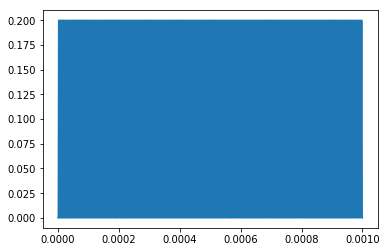

In [10]:
#%matplotlib auto
plt.plot(t_vec, wfmData)
#plt.xlim([1e-3-2e-4,1e-3])

In [11]:
#==== 将波形数据发送给仪器 ====
if (wfm_name in awg.query('WLIST:LIST?')):
    awg.write('AWGCONTROL:STOP:IMMEDIATE')
    awg.write('WLIST:WAVEFORM:DELETE "%s"'%wfm_name)
    awg.query('*opc?')
setWfm_func(awg, wfm_name, recordLength, wfmData, N_output)
awg.query('*opc?')
#time.sleep(2)

'1'

## 输出参照信号

In [12]:
def AWG_squareReference_seting(n_index):
    #生成参照信号
    wfm_name  = 'ref_wfm'
    N_output  = 2

    ref_freq = n_index * freq_square
    ref_T    = 1 / ref_freq
    V0_ref   = 0.4
    
    #
    t_vec     = np.linspace(0, tf, (recordLength+1), dtype=np.float32)[:-1]  #扔掉末尾的点
    dt        = t_vec[1]-t_vec[0]
    wfmData   = np.zeros(t_vec.size)
    
    #initiate time flag
    time_new  = 0
    time_old  = 0
    pos_new   = 0
    pos_old   = 0
    
    while True:
        time_new   = time_new + ref_T/2
        if (time_new > tf):
            wfmData[pos_old:] = 0.5*V0_ref
            break
        #find pos
        pos_new                  = int(time_new / dt)
        wfmData[pos_old:pos_new] = 0.5*V0_ref
        V0_ref                   = -1*V0_ref
        #refresh pos_old
        pos_old = pos_new
            
    #==== 将波形数据发送给仪器 ====
    if (wfm_name in awg.query('WLIST:LIST?')):
        awg.write('AWGCONTROL:STOP:IMMEDIATE')
        awg.write('WLIST:WAVEFORM:DELETE "%s"'%wfm_name)
        awg.query('*opc?')
    setWfm_func(awg, wfm_name, recordLength, wfmData, N_output)
    awg.query('*opc?')

In [13]:
AWG_squareReference_seting(7)

# UHF

In [14]:
device_id    = 'dev2374'
apilevel     = 6
(daq, device, _) = zhinst.utils.create_api_session(device_id, apilevel)
_=zhinst.utils.disable_everything(daq, device)

Discovered device `dev2374`: UHFLI with options .
Creating an API session for device `dev2374` on `127.0.0.1`, `8004` with apilevel `6`.


In [15]:
def ziDAQ(double_or_int, path, value):
    if (double_or_int == 'setDouble'): daq.setDouble(path, value)
    if (double_or_int == 'setInt'):    daq.setDouble(path, value)

def UHF_ready_check():
    zhinst.utils.api_server_version_check(daq)

## Input Channel Setting

### Signal Channel

In [16]:
#input channel
ziDAQ('setInt', '/dev2374/sigins/0/imp50', 1)
ziDAQ('setInt', '/dev2374/sigins/0/ac', 0)
ziDAQ('setInt', '/dev2374/sigins/0/autorange', 1)

#lockin channel
ziDAQ('setInt', '/dev2374/demods/0/order', 4)
ziDAQ('setDouble', '/dev2374/demods/0/timeconstant', 0.1)

#data transfer
ziDAQ('setInt', '/dev2374/demods/0/enable', 1);
ziDAQ('setDouble', '/dev2374/demods/0/rate', 439.5e3)

UHF_ready_check()

### Reference Channel

In [17]:
#input channel
ziDAQ('setInt', '/dev2374/demods/3/adcselect', 2)
ziDAQ('setInt', '/dev2374/extrefs/0/enable', 1)

UHF_ready_check()

In [18]:
def readBiChannelXY_func(timeLength=1, average=True):
    # Unsubscribe any streaming data.
    daq.unsubscribe('*')

    # Perform a global synchronisation between the device and the data server:
    # Ensure that 1. the settings have taken effect on the device before issuing
    # the poll() command and 2. clear the API's data buffers. Note: the sync()
    # must be issued after waiting for the demodulator filter to settle above.
    daq.sync()

    # Subscribe to the demodulator's sample node path.
    path1 = '/dev2374/demods/0/sample'
    daq.subscribe(path1) #UHF的DEMOD0从这里开始记录数据 
    path2 = '/dev2374/demods/4/sample'
    daq.subscribe(path2) #UHF的DEMOD4从这里开始记录数据
    
    #poll data
    # Poll the subscribed data from the data server. Poll will block and record
    # for poll_length seconds.
    poll_length = timeLength  # [s]
    poll_timeout = 500  # [ms]
    poll_flags = 0
    poll_return_flat_dict = True

    sample = daq.poll(poll_length, poll_timeout, poll_flags, poll_return_flat_dict)
    
    # Unsubscribe from all paths.
    daq.unsubscribe('*')
    
    #data
    X1_vec  = sample[path1]['x']*np.sqrt(2) 
    Y1_vec  = sample[path1]['y']*np.sqrt(2)
    #时间坐标
    timestamp1 = sample[path1]['timestamp']
    timestamp0 = timestamp1[0]
    clockbase  = float(daq.getInt('/dev2374/clockbase'))
    t1_vec     = (timestamp1 - timestamp0)/clockbase
    
    if (average == True): return [np.average(X1_vec),np.average(Y1_vec)]
    else:                 return [t1_vec, X1_vec, Y1_vec]

In [19]:
scope_length = 2**16
scope_time   = 16
in_channel   = 0

#==========================================================================
# Configure the scope and obtain data with triggering disabled.
daq.setInt('/%s/scopes/0/length' % device, scope_length)
daq.setInt('/%s/scopes/0/channel' % device, 1)
daq.setInt('/%s/scopes/0/channels/%d/bwlimit' % (device, in_channel), 1)
daq.setInt('/%s/scopes/0/channels/%d/inputselect' % (device, in_channel), 0)
daq.setInt('/%s/scopes/0/single' % device, 1)
daq.setInt('/%s/scopes/0/time' % device, scope_time)
daq.setInt('/%s/scopes/0/segments/count' % device, 1)


#trigger
daq.setInt('/%s/scopes/0/trigenable' % device, 0)
daq.setDouble('/%s/scopes/0/trigholdoff' % device, 0.050)
daq.setInt('/%s/scopes/0/segments/enable' % device, 0)
daq.sync()

#==========================================================================
# Now initialize and configure the Scope Module.
scopeModule = daq.scopeModule()
scopeModule.set('mode', 1)
scopeModule.set('averager/weight', 1) #   weight=1 - don't average.
scopeModule.set('historylength', 1)
scopeModule.subscribe('/dev2374/scopes/0/wave')

def readScope_func():
    #zhinst.utils.sigin_autorange(daq, device, in_channel) #调整输入端的range（ADC前的放大器）
    # Tell the module to be ready to acquire data; reset the module's progress to 0.0.
    scopeModule.execute()

    # Enable the scope: Now the scope is ready to record data upon receiving triggers.
    daq.setInt('/%s/scopes/0/enable' % device, 1)
    daq.sync()

    start = time.time()
    timeout = 5  # [s]
    records = 0
    # Wait until the Scope Module has received and processed the desired number of records.
    while (records < 1):
        time.sleep(0.1)
        records = scopeModule.getInt("records")
        #progress = scopeModule.progress()[0]
        if (time.time() - start) > timeout:
            print("\nTimeout!\n")
            break    

    # Stop the module; to use it again we need to call execute().
    scopeModule.finish()  #在读取数据前停止module，防止继续读取数据

    # Read out the scope data from the module.
    daq.setInt('/%s/scopes/0/enable' % device, 0)


    data_return = scopeModule.read(True)['/dev2374/scopes/0/wave']
    voltage_vec = data_return[0][0]['wave'][0]
    delta_t     = data_return[0][0]['dt']
    t_vec       = delta_t*np.arange(0,len(voltage_vec))
    return [t_vec, voltage_vec]

## UHF-Lockin Test

In [20]:
#XY from lockin-amplifer
[X, Y] = readBiChannelXY_func(timeLength=1)
print("X=%.3f mV"%(X/np.sqrt(2)*1e3), "Y=%.3f mV"%(Y/np.sqrt(2)*1e3) )

X=0.093 mV Y=4.514 mV


# Measure Cn

In [21]:
Nn     = 8
Cn_vec = np.zeros(Nn, dtype=complex)

In [22]:
#DC measurement
[t_vec, voltage_vec] = readScope_func()
Cn_vec[0] = np.average(voltage_vec)

In [23]:
#AC measurement
for n in tqdm(range(1,Nn)):
    #set refence signal
    n_index = n
    AWG_squareReference_seting(n_index)
    AWG_read_check()
    time.sleep(2)
    
    #measure Cn
    #UHF_ready_check()
    [X, Y]    = readBiChannelXY_func(timeLength=5)
    Cn_vec[n] = 0.5j*X + 0.5*Y
    time.sleep(2)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:14<00:00, 10.71s/it]


# Signal Recover

In [24]:
t_vec             = np.linspace(0,1e-5,1001)[:-1]
squareRecover_vec = np.zeros(t_vec.size)

#DC recover
squareRecover_vec = squareRecover_vec + Cn_vec[0]

#AC recover
for n in range(1, Cn_vec.size):
    omega             = 2*np.pi*freq_square
    Cn                = Cn_vec[n]
    squareRecover_vec = squareRecover_vec + np.exp(-1j*n*omega*t_vec) * Cn + np.exp(1j*n*omega*t_vec) * Cn.conj()

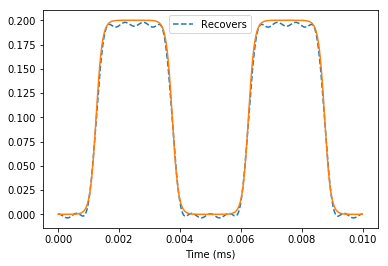

In [25]:
plt.plot(t_vec*1e3, squareRecover_vec.real, '--', label='Recovers')
plt.plot(t_vec*1e3, squarePeriodic_func(t_vec, T, V0))
plt.xlabel('Time (ms)')
plt.legend()
plt.savefig("pic_name.png", format='png', dpi=200)
#plt.xlim([0,10])